#  Machine Learning to Excise RFI 


## The VLA

The Very Large Array (VLA) is one of the most state of art interferometers. It is located on the Plains of San Augustin, New Mexico, USA. It consists of 27 radio antennas arranged in a Y shape. Each antenna has a 25m diameter [1].

In its D configuration, the interferometer consists of 351 baselines with lenghts varrying between 35m and 1km.

For this project, the frequency band in which the measurements are taken is the L-band (1GHz - 2GHz).

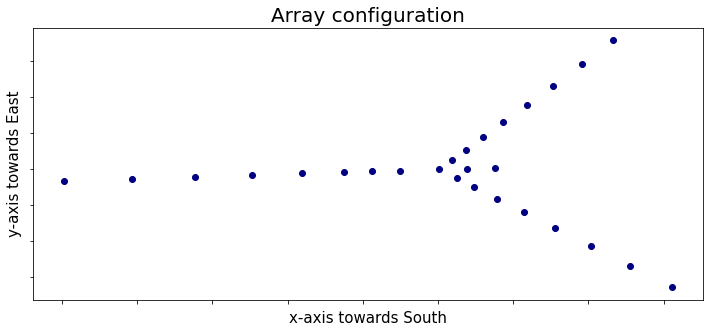

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
%matplotlib inline
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)


n=27 # Number of arrays

# XYZ coordinates as measure from the centre of the array 
# https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview

x = np.array([76.69,49.29,94.46,156.49,228.83,311.96,405.7,509.53,623.12,151.29,37.71,73.37,118.76,173.02,235.66,305.29,381.68,465.79,2.24,-100.24,-174.91,-249.59,-361.68,-495.55,-645.82,-812.58,-995.39])
y = np.array([11.67,-123.87,-248.46,-407.06,-597.84,-817.22,-1064.49,-1338.54,-1638.19,23.33,135.65,271.95,445.77,653.27,893.16,1163.76,1463.33,1790.89,0.05,-15.93,-27.56,-39.15,-56.66,-77.43,-100.9,-126.88,-155.53])
z = np.array([-108.36,-67.42,-136.94,-225.51,-331.98,-454.39,-592.36,-745.23,-912.51,-218.44,-50.59,-103.23,-170.46,-250.51,-343.18,-448.46,-565.35,-692.95,171,152.45,262.39,372.31,537.09,733.79,955.52,1200.98,1469.71])

# arrays for the difference between the x and y coordinates
# of each baseline's antennas
L_x = []
L_y = []
L_z = []
# calculate the difference
for i in range(0,n):
    for j in range(0,n):
        if i < j:
            Lx = x[j]-x[i]
            Ly = y[j]-y[i]
            Lz = z[j]-z[i]
            L_x.append(Lx)
            L_y.append(Ly)
            L_z.append(Lz)

# positions are given in ns as the time it takes time to travel from the centre
# to the antenna so need to convert in SI units
L_x = np.array(L_x)*1e-9*const.c.value
L_y = np.array(L_y)*1e-9*const.c.value
L_z = np.array(L_z)*1e-9*const.c.value


fig,ax = plt.subplots(1,figsize=(12,5))
ax.plot(x,y, color = 'navy', marker = 'o',linestyle='')
ax.set_ylabel('y-axis towards East', fontsize='15')
ax.set_xlabel('x-axis towards South', fontsize='15')
plt.title('Array configuration', fontsize='20')
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

## Constructing the spectra

In order to construct the spectra, we need to look at the coverage of the U-V plane by the interferometer and then calculate the value of the response function of each baseline at each frequency and value of the hour angle HA. [2]

The target source are Source 1, in the centre of the field of view, with coordinates right ascension $RA_1 = 05h 00m 00s$ and declination $D_1 = 45^{\circ}00'00"$, and Source 2, with coordinates $RA_2 = 05h 00m 10s$ and declination $D_2 = 45^{\circ}03'00"$. Source 1 has a flux density of 3.6 Jy and Source 2 has a flux density of 5.8 Jy.

Each baseline covers the U-V plane by measuring points for every value of the HA of the source in the centre of the field of view. The points obtained will be separated in units of wavelength at which the observation is made. Thus, the functions describing U and V are:
\begin{equation}
    u = \frac{1}{\lambda}(\cos{H}L_y + \sin{H}L_x)
\end{equation}
\begin{equation}
    v = \frac{1}{\lambda}(\sin{D}\sin{H}L_y  - \sin{D}\cos{H}L_x + \cos{D}L_z)
\end{equation}

The response function of the interferometer is a function of object flux desity, U-V coverage, and the direction cosine, $l_0$ and $m_0$. For the source situated at the centre of the field of view, both $l_0$ and $m_0$ are 0. However, for Source 2, these values are: 
\begin{equation}
    l_0 = RA_2 - RA_1
\end{equation}
\begin{equation}
    m_0 = D_2 - D_1
\end{equation}
The response function formula is:
\begin{equation}
    R = \int {\int{ I e^{2\pi i(u l_0 + v m_0)}}\,du}\,dv
\end{equation}
Because there are two sources in our field of view, the response for each source becomes:
\begin{equation}
    R_1 = I_1
\end{equation}
and 
\begin{equation}
  R_2 = I_2 e^{2\pi i(u l_0 + v m_0)}
\end{equation}
The total response function is a sum of the two.


In [3]:
# function to calculate the uv coverage for a baseline in an interval of 
# time represented by hour angles
def uv_coverage(Lx,Ly,Lz,H,D,w):
    u = 1/w*(np.cos(H)*Ly + np.sin(H)*Lx)
    v = 1/w*(np.sin(D)*np.sin(H)*Ly  - np.sin(D)*np.cos(H)*Lx + np.cos(D)*Lz)
    return u,v

# funtion to calculate the response value for an object 
# for a given u,v coverage
def R_val(I, l_0, m_0, u, v):
    R = I*np.exp(2*np.pi*1j*(u*l_0+v*m_0))
    return R

The U-V coverage depends on the frequency of the observation, so observations made in the L-band (1GHz - 2GHz) will have different values for each different frequency in that interval. For the purpose of this project, the bandwith was split in 64 frequency channels. The response function was then calculated for each baseline, at each frequency channel in the L-band, for every value of the HA of Source 1. The integration time chosen was 30s.

In [17]:
H1 = np.linspace(-22.5,22.5,360)*np.pi/180 
D1 = np.pi/4
H2 = np.linspace(-25,25,360)*np.pi/180
D2 = np.pi*(1/4 + 1/3600)
RA1 = 5*np.pi/12
RA2 = 1.31
l_0 = D2 - D1 
m_0 = RA2 - RA1
freq_channels = np.linspace(1e9,2e9,64)
I_1 = 3.6
I_2 = 5.8
spectra = []

# using the functions defined above, calculate the response
# for each baseline, frequency in the frequency channel,
# and hour angle
for i in range(0,len(L_x)):
    lx= L_x[i]
    ly= L_y[i]
    lz= L_z[i]
    R_values  = []
    for j in range(0,len(freq_channels)) :
        w = const.c.value/freq_channels[j]
        u,v = uv_coverage(lx,ly,lz,H1,D1,w)
        R_1 = R_val(I_1,0,0,u,v)
        R_2 = R_val(I_2,l_0,m_0,u,v)
        R = R_1 + R_2
        R_values.append(abs(R))
    spectra.append(R_values)
    

The spectra was then constructed as a 3 - dimensional array of shape (351,128,360). An example of how such a spectrogram looks can be seen underneath.

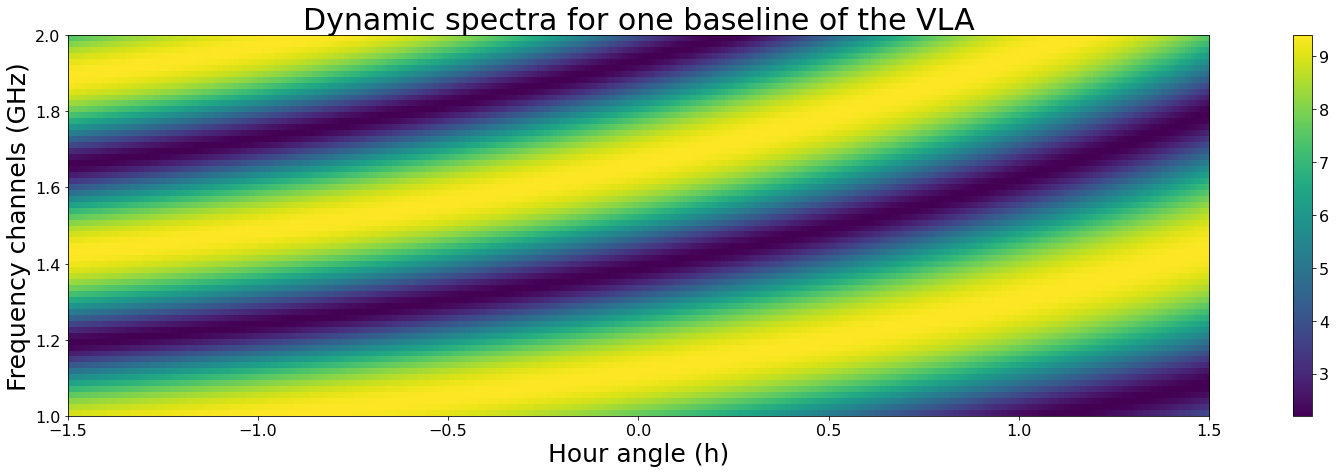

In [18]:
spectra = np.array(spectra)
plt.figure(figsize=(30,7))
plt.title('Dynamic spectra for one baseline of the VLA', fontsize=30)
plt.ylabel('Frequency channels (GHz)', fontsize=25)
plt.xlabel('Hour angle (h)', fontsize=25)
plt.imshow(spectra[50],origin='lower',interpolation=None, extent=[-1.5,1.5,1,2])
plt.colorbar()

The calculated spectra are for the ideal case, where antenna components are ideal and there is no interference from the exterior. However, this is not the true case. 

In reality, antenna components introduce a Gaussian noise, whose values depend on the antenna efficiency $\eta$ (~70% for a VLA antenna), antenna apperture A, the system temperature $T_{sys}$, the bandwidth $\Delta \nu$ (in our case 1GHz), integration time $t_{int}$, and the number of baselines $n_b$ [2]:

\begin{equation}
  rms~noise = \frac{k_B~ T_{sys} ~\sqrt{2}}{A~\eta\sqrt{~ n_b ~t_{int}~ \Delta ~\nu}}
\end{equation}

This noise is added to the response function values.

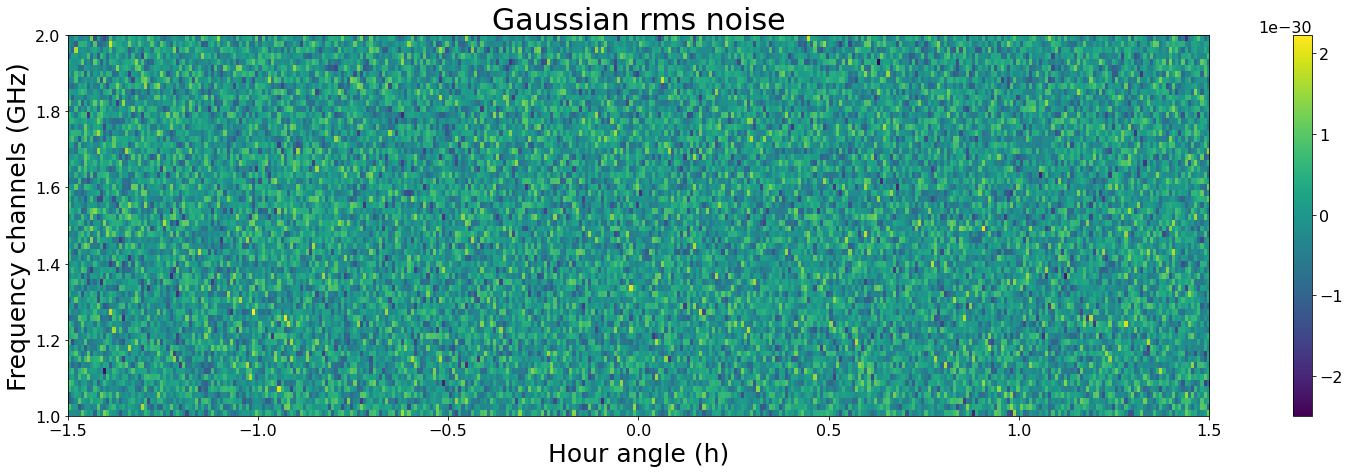

In [19]:
# for L band [3]
T_sys = 32
A_e = 12.5**2*np.pi*0.7 
rms = const.k_B.value*T_sys*np.sqrt(2)/(A_e*np.sqrt(len(L_x)*30*1e9))
noise = np.random.normal(0, rms, spectra.shape)
spectra_noisy = spectra + noise
plt.figure(figsize=(30,7))
plt.title('Gaussian rms noise', fontsize=30)
plt.ylabel('Frequency channels (GHz)', fontsize=25)
plt.xlabel('Hour angle (h)', fontsize=25)
plt.imshow(noise[50],origin='lower',interpolation=None, extent=[-1.5,1.5,1,2])
plt.colorbar()

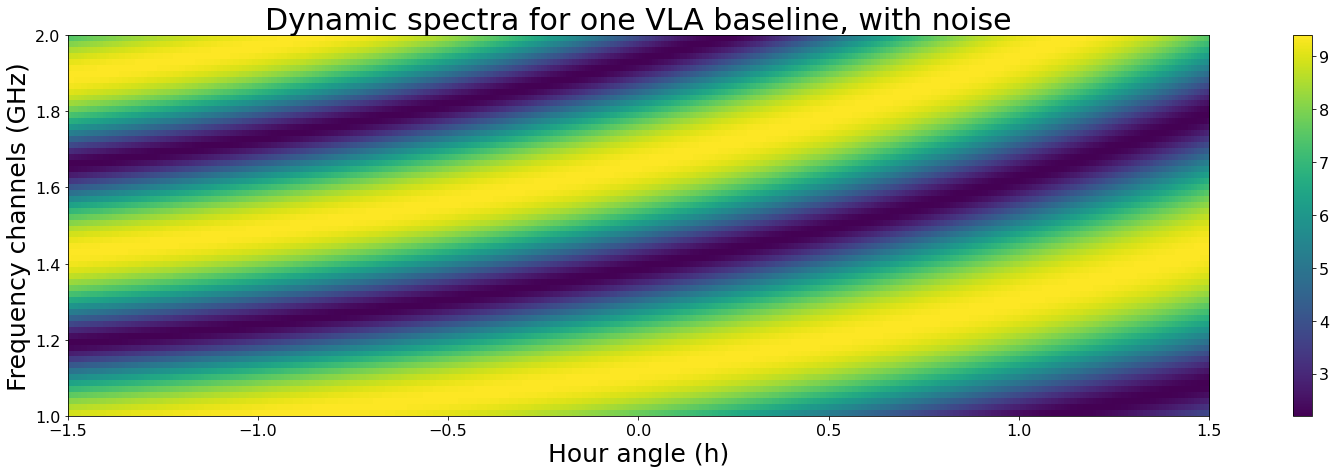

In [20]:
# for L band https://library.nrao.edu/public/memos/vla/test/VLAT_170.pdf
plt.figure(figsize=(30,7))
plt.title('Dynamic spectra for one VLA baseline, with noise', fontsize=30)
plt.ylabel('Frequency channels (GHz)', fontsize=25)
plt.xlabel('Hour angle (h)', fontsize=25)
plt.imshow(spectra_noisy[50],origin='lower',interpolation=None, extent=[-1.5,1.5,1,2])
plt.colorbar()

Radio frequency interference, or RFI, is created as various radio signals from Earth or near Earth.
For this project, ten RFI sources have been selected and added to the spectra. For each source selected for this project, the source name, whether it is continuous (C) or intermitent(I), its amplitude, and its frequency can be seen in the table below [4]. 

| Name | I / C | Amplitude (Jy) | Frequency (MHz) |
| --- | --- | --- | --- |
| Aircraft | I | 1 | 1025-1150|
| GPS L2 | C | 0.1 | 1250 |
| Radar | I | 0.32 | 1268 |
| GPS L1 | C | 2 | 1570 |
| IRIDIUM satellite | C| 1 | 1620 |
| GOES weather balloon | I | 2 | 1690 |
| PCS cell phone base stations | C | 1.3 | 1900 |
| VLA modem | C | 0.25 | 1200 |
| RASCAT | I | 0.8 | 1000 |
| FAA | C | 0.25 | 1310 |

In [44]:
# create 10 RFI sources
val_1 = []
val_2 = []
val_3 = []
val_4 = []
val_5 = []
val_6 = []
val_7 = []
val_8 = []
val_9 = []
val_10 = []
for i in range(0,360):
    if i<10:
        val_1.append(1)
    else:
        val_1.append(0)
    val_2.append(0.1)
    if 75<i<255:
        val_3.append(0.32)
    else:
        val_3.append(0)
    val_4.append(2)
    val_5.append(1)
    if 42<i<130:
        val_6.append(2)
    else:
        val_6.append(0)
    val_7.append(1.3)
    val_8.append(0.25)
    if 9<i<20:
        val_9.append(0.8)
    else:
        val_9.append(0)
    val_10.append(0.25)


val_1 = np.array(val_1)
val_2 = np.array(val_2)
val_3 = np.array(val_3)
val_4 = np.array(val_4)
val_5 = np.array(val_5)
val_6 = np.array(val_6)
val_7 = np.array(val_7)
val_8 = np.array(val_8)
val_9 = np.array(val_9)
val_10 = np.array(val_10)


In [48]:
# create a 3d matrix of the same shape as the spectra
# and add RFI sources 
RFI = np.zeros(spectra_noisy.shape)

# frequency channel number corresponding to each RFI source frequency
interference = np.array([2,16,17,36,39,44,57,12,0,19])

# add the RFI spurces to the response values for the 
# frequency channel corresponding to each RFI source
for i in range(0, len(RFI)):
    for j in range(0, len(RFI[0])):
        if j==interference[0]:
            RFI[i][j] = RFI[i][j] + val_1
        if j==interference[1]:
            RFI[i][j] = RFI[i][j] + val_2
        if j==interference[2]:
            RFI[i][j] = RFI[i][j] + val_3
        if j==interference[3]:
            RFI[i][j] = RFI[i][j] + val_4
        if j==interference[4]:
            RFI[i][j] = RFI[i][j] + val_5
        if j==interference[5]:
            RFI[i][j] = RFI[i][j] + val_6
        if j==interference[6]:
            RFI[i][j] = RFI[i][j] + val_7
        if j==interference[7]:
            RFI[i][j] = RFI[i][j] + val_8
        if j==interference[8]:
            RFI[i][j] = RFI[i][j] + val_9
        if j==interference[9]:
            RFI[i][j] = RFI[i][j] + val_10


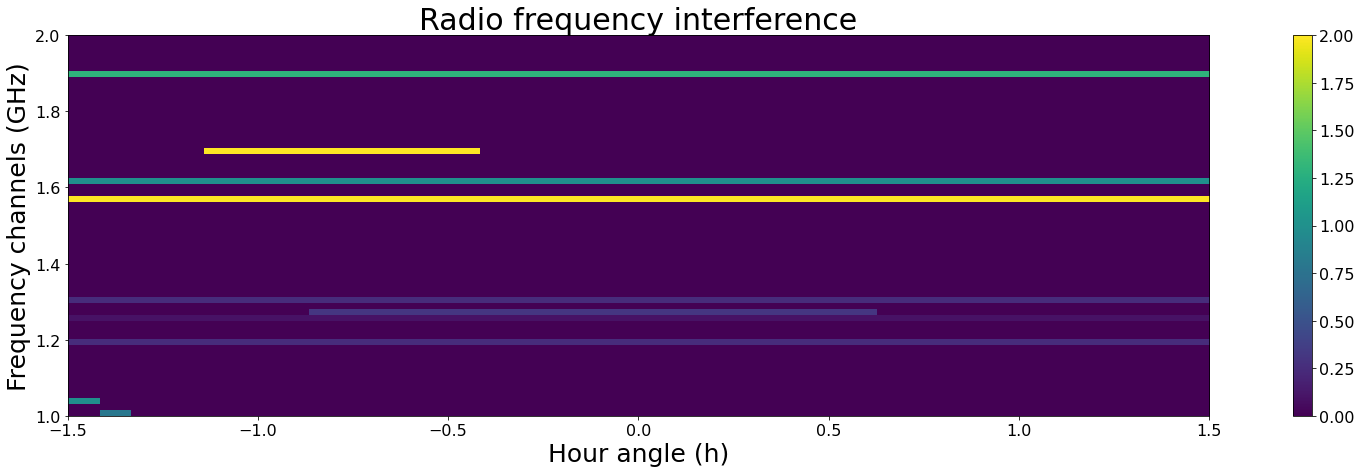

In [49]:
plt.figure(figsize=(30,7))
plt.title('Radio frequency interference', fontsize=30)
plt.ylabel('Frequency channels (GHz)', fontsize=25)
plt.xlabel('Hour angle (h)', fontsize=25)
plt.imshow(RFI[1],origin='lower',interpolation=None, extent=[-1.5,1.5,1,2])
plt.colorbar()

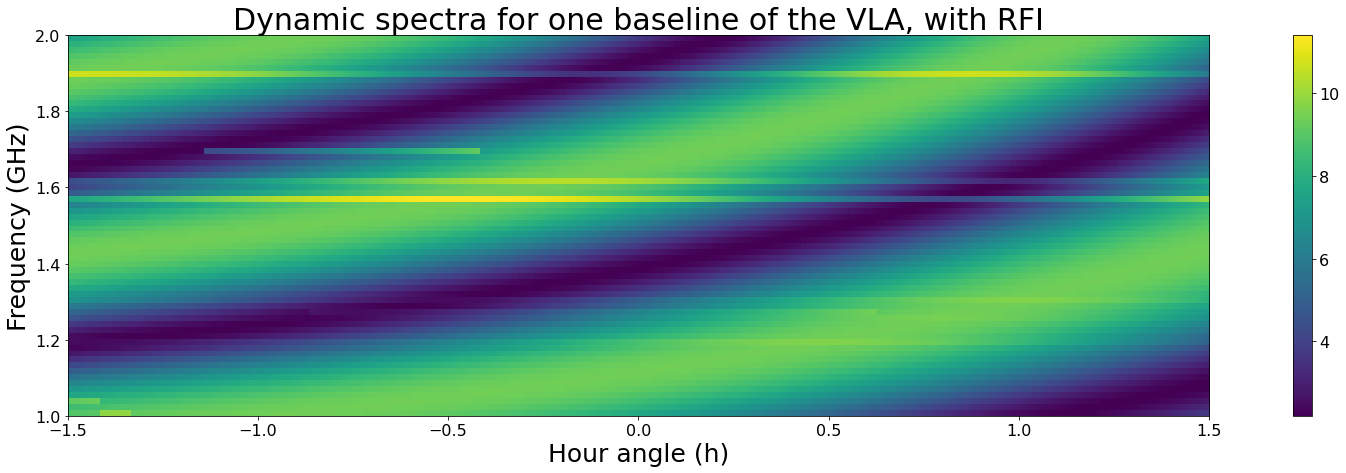

In [51]:
spectra_full = spectra_noisy + RFI
plt.figure(figsize=(30,7))
plt.title('Dynamic spectra for one baseline of the VLA, with RFI', fontsize=30)
plt.ylabel('Frequency (GHz)', fontsize=25)
plt.xlabel('Hour angle (h)', fontsize=25)
plt.imshow(spectra_full[50],origin='lower',interpolation=None, extent=[-1.5,1.5,1,2])
plt.colorbar()

## Isolation forest classification

The machine learning algorithm we chose for this project is called an Isolation Forest (IF). The algorithm was defined by Fei Tony Liu in 2008 [5], and is a form of unsupervised machine learning.

The algorithm works by splitting the data along two axes and checking to see which points have been isolated by this. The point isolated is then marked as an anomaly.

If we sum up the measured response function values across all time, then the amplitude of the summed response function will look like the figure below. If RFI is present, we can observe spikes in the sinusoid. 

By using an IF classification on this data, we would hope to isolate the spikes and thus determine which amplitudes are from the sources we want to observe, and which amplitudes are RFI sources. 

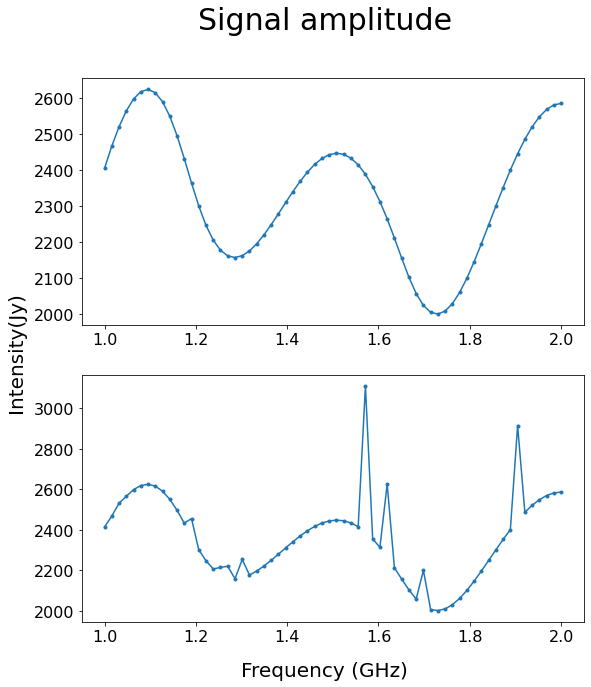

In [52]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(9,10),)
fig.suptitle('Signal amplitude', fontsize=30)
fig.text(0.01,0.5,'Intensity(Jy)', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.05,'Frequency (GHz)', ha='center',fontsize=20)
ax1.plot(freq_channels/1e9,np.sum(spectra_noisy[50],axis=1),'.',linestyle='-')
ax2.plot(freq_channels/1e9,np.sum(spectra_full[50],axis=1),'.',linestyle='-')

The graph above shows how the signal recorded by a baseline, integrated over the full observation time, looks without and with RFI.

The algorithm used is from the sklearn package [6].

The contamination number is the proportion of anomalies in the dataset, in this case ~15%.

In [101]:
from sklearn.ensemble import IsolationForest

#choose a number of times the training should be repeated
epoch_number = 10

# prepare to save predictions
y_pred_train =[]

# define the model
clf = IsolationForest(contamination=0.15)

# select training data to be the data for the first 100 baselines
for i in range(0,100): 
    for j in range(0,epoch_number):
        X_train = spectra_full[0]
        # fit the model
        clf.fit(X_train)
    # save the prediction
    y_pred_train.append(clf.predict(X_train))

# save the predictions
y_pred_train = np.array([y_pred_train])


In [102]:
# find at which positions in the training array
# the algorithm predicts will be an anomaly
# and then save the values

an_ind_train = np.where(y_pred_train[0][50]<0)
anomalies = spectra_full[50][an_ind_train[0]]
anomaly_freq = freq_channels[an_ind_train[0]]/1e9
print(an_ind_train)

(array([12, 17, 19, 36, 39, 44, 57, 61, 62, 63], dtype=int64),)


The figure below shows the training signal in blue and the predicted RFI peaks in red.

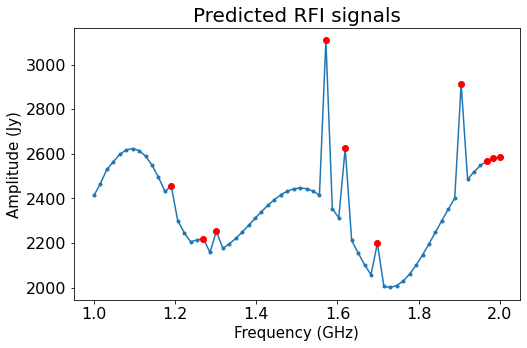

In [103]:
plt.figure(figsize=(8,5))
plt.title('Predicted RFI signals', fontsize=20)
plt.xlabel('Frequency (GHz)', fontsize=15)
plt.ylabel('Amplitude (Jy)', fontsize=15)
plt.plot(freq_channels/1e9,np.sum(spectra_full[50],axis=1), '.',linestyle='-')
plt.plot(anomaly_freq,np.sum(anomalies,axis=1),'ro')

In order to evaluate the performance of the classification, we use sklearn's classification report [7].

The values returned by this function are the precision, recall, and $F_1$ score.

The precision represents the percentage of negatives, i.e. non-RFI signals, correctly identified by the classifier.

The recall quantifies the proportion of positive siganl, i.e. RFI sources, correctly identified by the algorithm.

Finally, the $F_1$ score metric represents the overall performance of the classifier.

In [104]:
from sklearn.metrics import classification_report
real = []
for i in range(0,len(freq_channels)):
    if i in interference:
        real.append(-1)
    else:
        real.append(1)
real= np.array(real)

print(classification_report(real,y_pred_train[0][50]))

              precision    recall  f1-score   support

          -1       0.70      0.70      0.70        10
           1       0.94      0.94      0.94        54

    accuracy                           0.91        64
   macro avg       0.82      0.82      0.82        64
weighted avg       0.91      0.91      0.91        64



For a random subset of the training data, this type of classifier performs quite well. It was able to correctly label 70% of the
RFI signals. It correctly predicted most of the RFI signals, apart from the ones observed at the low end of the frequency band. Due to the fact that it missed those first frequency channels' RFI, it overfit the higher end of the frequency band.

However, when required to predict a random previously unseen test, it performs very poorly, with a precision of less than 20%. It predicted RFI signals in 64 of the 64 channels of the frequency band.

In [116]:
# Test predictions on data for another previously unseen baseline
X_test_1 = spectra_full[200]
y_pred_test = clf.predict(X_test_1)
print(len(np.where(y_pred_test<0)[0]))

64


In [117]:
print(classification_report(real,y_pred_test,zero_division=0))

              precision    recall  f1-score   support

          -1       0.16      1.00      0.27        10
           1       0.00      0.00      0.00        54

    accuracy                           0.16        64
   macro avg       0.08      0.50      0.14        64
weighted avg       0.02      0.16      0.04        64



In conclusion, such an algorithm could be very powerful for identifying and extracting RFI, provided that the model is trained over the data set before it is required to predict it, and as long as we are aware of the expected amount of RFI in a given observation. 

With the upcoming launch of thousands of satellites by big companies, RFI is going to become more and more of an issue. Because of this, we need reliable methods of RFI extraction, and the IF algorithm could be one of these methods.

## Bibliography

[1] https://science.nrao.edu/facilities/vla/docs/manuals/propvla/array_configs

[2] PHYS64591 Radio Astronomy theory

[3] https://library.nrao.edu/public/memos/vla/test/VLAT_170.pdf

[4] https://science.nrao.edu/facilities/vla/observing/RFI/L-Band

[5] F. T. Liu, K. M. Ting and Z. Zhou, "Isolation Forest," 2008 Eighth IEEE International Conference on Data Mining, Pisa, 2008, pp. 413-422, doi: 10.1109/ICDM.2008.17. https://ieeexplore.ieee.org/document/4781136

[6] : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

[7] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html